In [1]:
import torch
from tqdm.auto import tqdm
from optree import tree_map
import matplotlib.pyplot as plt

import uqlib

from load import load_dataloaders, load_model

In [2]:
# Load data
train_dataloader, eval_dataloader = load_dataloaders(small=True, batch_size=32)
num_data = len(train_dataloader.dataset)
print("Full training data size: ", num_data)

Full training data size:  1000


In [3]:
# Load model (with standard Gaussian prior)
model, param_to_log_posterior = load_model(num_data=num_data, prior_sd=1e3)

# Turn off Dropout
model.eval()

# Load to GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device);

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Only train the last layer
for name, param in model.named_parameters():
    if 'bert' in name:
        param.requires_grad = False

In [5]:
# Store initial parameter values to check against later
init_params = tree_map(lambda p: p.detach().clone(), dict(model.named_parameters()))

In [6]:
# Train using SGHMC
sampler = uqlib.sgmcmc.optim.SGHMC(model.parameters(), lr=1e-2, alpha=1e-3, temperature=1/num_data, maximize=True)

num_epochs = 30
num_training_steps = num_epochs * len(train_dataloader)

progress_bar = tqdm(range(num_training_steps))

log_posts = []

# model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        log_post = param_to_log_posterior(dict(model.named_parameters()), batch)

        log_post.backward()
        log_posts.append(log_post.item())
        
        print(log_posts[-1], end='\r')

        sampler.step()
        sampler.zero_grad()
        progress_bar.update(1)

  0%|          | 0/960 [00:00<?, ?it/s]

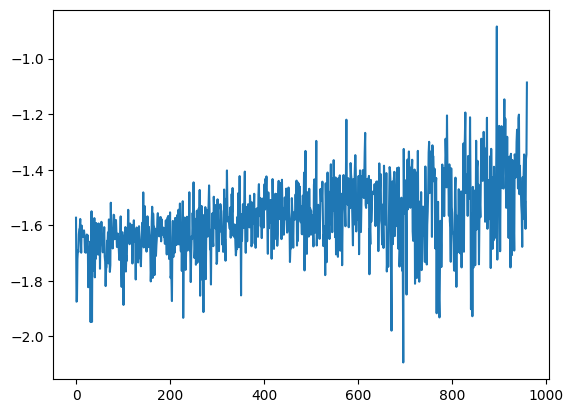

In [7]:
# Plot convergence
plt.plot(log_posts);

In [7]:
final_params = tree_map(lambda p: p.detach().clone(), dict(model.named_parameters()))

In [8]:
init_trained_params = torch.cat([v.flatten() for k, v in init_params.items() if 'bert' in k])
init_untrained_params = torch.cat([v.flatten() for k, v in init_params.items() if 'bert' not in k])

In [9]:
final_trained_params = torch.cat([v.flatten() for k, v in final_params.items() if 'bert' in k])
final_untrained_params = torch.cat([v.flatten() for k, v in final_params.items() if 'bert' not in k])

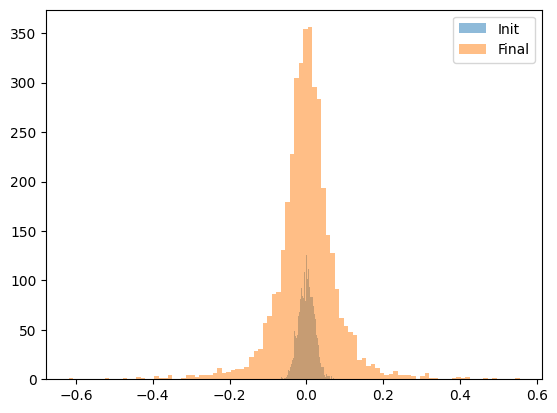

In [10]:
# Visualize trained sub_params vs their initial values
plt.hist(init_untrained_params.cpu().numpy(), bins=100, alpha=0.5, label='Init')
plt.hist(final_untrained_params.cpu().numpy(), bins=100, alpha=0.5, label='Final')
plt.legend();

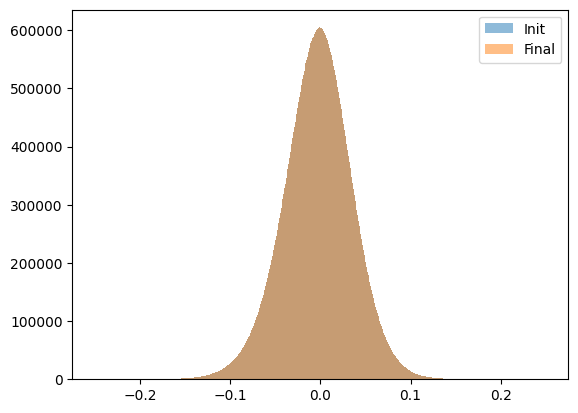

In [11]:
# Check pretrained BERT params are unchanged
xrange = (-0.25, 0.25)
plt.hist(init_trained_params.cpu().numpy(), bins=1000, alpha=0.5, label='Init', range=xrange)
plt.hist(final_trained_params.cpu().numpy(), bins=1000, alpha=0.5, label='Final', range=xrange)
plt.legend();

In [13]:
torch.allclose(init_trained_params, final_trained_params)

True